# VolSense Notebook 04 — Cross-Sector Signals & Market Intelligence

## 1️⃣ Notebook Overview

This notebook explores the **Signal Engine** — the final stage of the VolSense workflow that translates raw forecasts and analytics into **interpretable market-level insights**:

* Understand the architecture and logic of `signal_engine.py`.
* Generate **sector-level volatility heatmaps**.
* Quantify **cross-horizon alignment** and **volatility divergence**.
* Produce **ticker-level relative strength signals** for trader decision support.

## 2️⃣ Imports & Setup

In [1]:

from volsense_inference.signal_engine import SignalEngine
from volsense_inference.forecast_engine import Forecast

## 3️⃣ Load Forecast Data

We’ll reuse the **v507 flagship model**, which provides the richest cross-sector forecasts.

In [2]:
fcast = Forecast(model_version="v507", checkpoints_dir="models")

# Pick 100 stable tickers from v507 universe (yfinance-compatible)

TICKERS = [
    # ----- Index / ETF -----
    "SPY","QQQ","DIA","IWM","GLD","SLV","TLT","HYG","EEM",

    # ----- Technology -----
    "AAPL","MSFT","GOOG","AMZN","META","NVDA","AVGO","AMD","INTC","ORCL",
    "TXN","QCOM","MU","CSCO","ADBE","NOW",

    # ----- Financials -----
    "JPM","BAC","C","WFC","GS","MS","V","MA",
    "BLK","USB","PNC","TFC","COF",

    # ----- Healthcare -----
    "JNJ","PFE","MRK","UNH","ABBV","ABT","LLY","BMY","TMO","CVS",
    "GILD","AMGN","REGN","MDT",

    # ----- Energy / Materials -----
    "XOM","CVX","COP","HAL","BHP","RIO","FCX",
    "EOG","LIN","APD",

    # ----- Consumer Discretionary -----
    "TSLA","HD","MCD","NKE","SBUX","BKNG","CMG",
    "LOW","MAR","EBAY",

    # ----- Industrials -----
    "CAT","BA","HON","UPS","FDX","LMT","GE","DE","RTX","NSC",

    # ----- Consumer Staples -----
    "PG","KO","PEP","COST","WMT","CL","KHC","TAP","MO",

    # ----- Communication Services -----
    "NFLX","DIS","T","VZ","TMUS","CMCSA","CHTR","EA"
]


print(f"✅ Loaded {len(TICKERS)} tickers for this run.")
preds = fcast.run(TICKERS)
print(preds.head())

🚀 Initializing VolSense.Forecast (model=v507)
✔ Window=40, Horizons=[1, 5, 10]
✅ Loaded 99 tickers for this run.

🌍 Running forecasts for 99 tickers...



Forecasting: 100%|██████████| 99/99 [00:05<00:00, 17.94it/s]

✅ Forecast complete.
  ticker  realized_vol  pred_vol_1  pred_vol_5  pred_vol_10  vol_diff  \
0    SPY      0.167461    0.189086    0.175042     0.156736  0.021626   
1    QQQ      0.225583    0.245931    0.229216     0.202779  0.020347   
2    DIA      0.131101    0.180351    0.166790     0.148092  0.049249   
3    IWM      0.253471    0.286894    0.270384     0.241377  0.033423   
4    GLD      0.394239    0.213718    0.203715     0.172158 -0.180521   

   vol_direction  
0            1.0  
1            1.0  
2            1.0  
3            1.0  
4           -1.0  


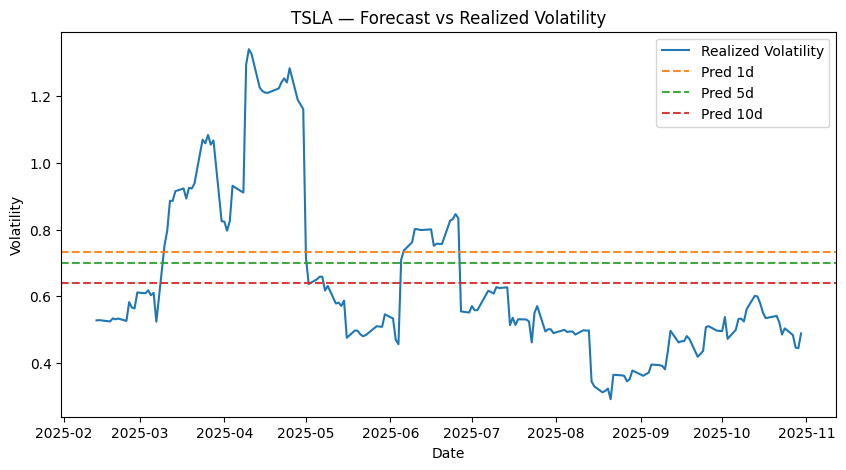

In [3]:
fcast.plot("TSLA")

## 4️⃣ Initialize SignalEngine

In [4]:
# Initialize and compute cross-sectional volatility signals
engine = SignalEngine(preds)
signals_df = engine.compute_signals()
print("✅ Computed volatility signals.")
signals_df.head()

⚙️ Computing cross-sectional signals for 99 tickers...
✅ Computed volatility signals.


,date,ticker,horizon,forecast_vol,today_vol,vol_zscore,vol_spread,term_spread_10v5,xsec_rank,signal_strength,regime_flag,sector,sector_mean,sector_std,sector_median,sector_z,rank_sector,rank_universe,position
0,2025-10-31,AAPL,1,0.375318,0.269253,0.051149,0.393926,-0.119682,0.595960,0.191919,normal,Technology,0.483444,0.144468,0.446946,1.420269,0.312500,0.595960,neutral
1,2025-10-31,AAPL,5,0.365782,NaN,0.138989,NaN,-0.119682,0.636364,0.272727,normal,Technology,0.460822,0.135983,0.429705,1.446849,0.312500,0.636364,neutral
2,2025-10-31,AAPL,10,0.322004,NaN,0.098624,NaN,-0.119682,0.636364,0.272727,normal,Technology,0.410932,0.120571,0.382674,1.486981,0.312500,0.636364,neutral
3,2025-10-31,ABBV,1,0.339330,0.118201,-0.239833,1.870794,-0.057139,0.414141,-0.171717,normal,Unknown,0.366642,0.022573,0.365508,0.236055,0.133333,0.414141,neutral
4,2025-10-31,ABBV,5,0.318787,NaN,-0.262297,NaN,-0.057139,0.414141,-0.171717,normal,Unknown,0.349589,0.023109,0.349450,0.256039,0.133333,0.414141,neutral


In [5]:
signals_df.columns

Index(['date', 'ticker', 'horizon', 'forecast_vol', 'today_vol', 'vol_zscore',
       'vol_spread', 'term_spread_10v5', 'xsec_rank', 'signal_strength',
       'regime_flag', 'sector', 'sector_mean', 'sector_std', 'sector_median',
       'sector_z', 'rank_sector', 'rank_universe', 'position'],
      dtype='object')

## What it does

`SignalEngine` integrates multi-ticker forecasts and analytics to derive:

* **Sector aggregates** → average or weighted volatility by sector.
* **Z-scores & standardized signals** → cross-sectional ranking of vol pressure.
* **Regime classification** → ‘Calm’, ‘Normal’, or ‘High Vol’ per sector.
* **Cross-horizon consistency** → measures whether short- and medium-term signals agree.

The result is a compact dataframe of **trader-readable signals** per ticker and sector.

## 5️⃣ Inspect Outputs

In [6]:
cols = [c for c in signals_df.columns if "signal" in c or "zscore" in c or "sector" in c or "position" in c]
signals_df[["ticker"] + cols].head(10)

,ticker,vol_zscore,signal_strength,sector,sector_mean,sector_std,sector_median,sector_z,rank_sector,position
0,AAPL,0.051149,0.191919,Technology,0.483444,0.144468,0.446946,1.420269,0.312500,neutral
1,AAPL,0.138989,0.272727,Technology,0.460822,0.135983,0.429705,1.446849,0.312500,neutral
2,AAPL,0.098624,0.272727,Technology,0.410932,0.120571,0.382674,1.486981,0.312500,neutral
3,ABBV,-0.239833,-0.171717,Unknown,0.366642,0.022573,0.365508,0.236055,0.133333,neutral
4,ABBV,-0.262297,-0.171717,Unknown,0.349589,0.023109,0.349450,0.256039,0.133333,neutral
5,ABBV,-0.112969,-0.111111,Unknown,0.315336,0.007807,0.316152,0.314513,0.133333,neutral
6,ABT,-0.961422,-0.696970,Healthcare,0.306665,0.094589,0.286872,-0.372029,0.153846,neutral
7,ABT,-0.953829,-0.696970,Healthcare,0.292352,0.093810,0.273516,-0.356707,0.153846,neutral
8,ABT,-0.936150,-0.696970,Healthcare,0.268694,0.085009,0.256430,-0.257554,0.153846,neutral
9,ADBE,0.409672,0.555556,Technology,0.483444,0.144468,0.446946,1.420269,0.437500,neutral


**Columns and what they mean:**

| Column           | Meaning                                                                                         |
| :--------------- | :---------------------------------------------------------------------------------------------- |
| `date`           | As-of date for the snapshot                                                                     |
| `ticker`         | Asset symbol                                                                                    |
| `horizon`        | Forecast horizon in days (e.g., 1, 5, 10)                                                       |
| `forecast_vol`   | Model’s forecasted volatility for the given horizon                                             |
| `today_vol`      | Realized volatility for the snapshot date (if available; otherwise NaN)                         |
| `vol_zscore`     | Cross-sectional z-score of `forecast_vol` within the same `horizon`                             |
| `vol_spread`     | Relative spread vs today’s vol: `(forecast_vol / today_vol) - 1` (NaN if `today_vol` missing)   |
| `xsec_rank`      | Percentile rank of `forecast_vol` within the same `horizon` in [0, 1]                           |
| `signal_strength`| Scaled rank in [-1, 1], where -1 is lowest and +1 is highest                                   |
| `regime_flag`    | Discrete regime by z-score: `calm` (< -1), `normal` ([-1, 1]), `spike` (> 1)                    |
| `sector`         | Sector label mapped from `sector_mapping.py`                                                    |
| `sector_mean`    | Mean of `forecast_vol` for the sector within the same `horizon`                                 |
| `sector_std`     | Standard deviation of `forecast_vol` for the sector within the same `horizon`                   |
| `sector_median`  | Median of `forecast_vol` for the sector within the same `horizon`                               |
| `sector_z`       | Cross-sectional z-score of `sector_mean` across sectors for the same `horizon` (snapshot)       |
| `rank_sector`    | Percentile rank of `forecast_vol` within its sector for the same `horizon`                      |
| `rank_universe`  | Percentile rank of `forecast_vol` across all tickers for the same `horizon`                     |
| `position`       | Derived stance from `vol_zscore`: `long`, `neutral`, or `short`                                 |

## 6️⃣ Sector Heatmap

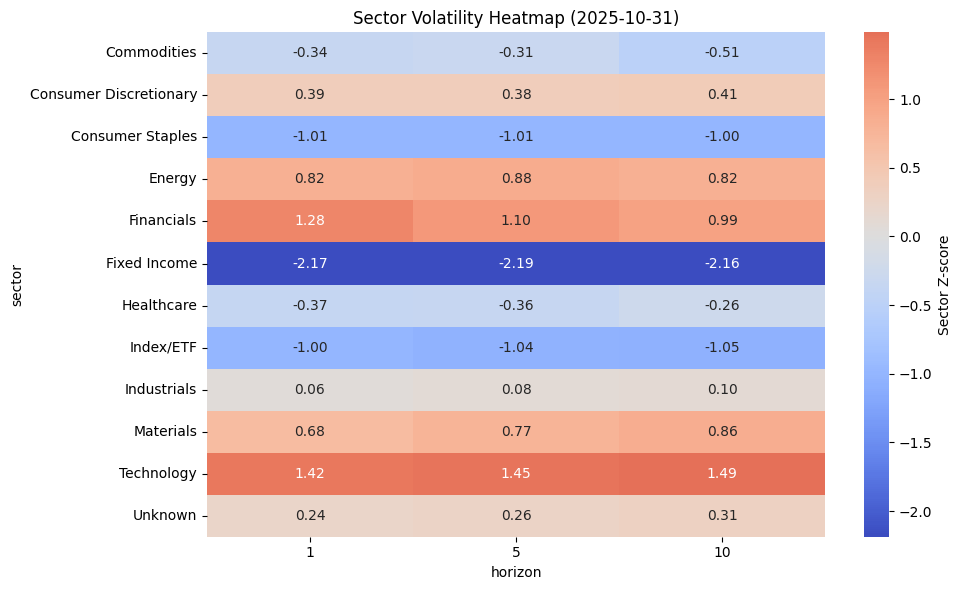

In [7]:
engine.plot_sector_heatmap()

> Interpretation
>
> * Colors correspond to sector-relative volatility z-scores.
> * Red → above-average volatility pressure (risk-off).
> * Blue → below-average volatility (risk-on or complacency).
> * Neutral → around mean, typical regime.
>
> This helps traders visualize which sectors are leading or lagging in volatility expansion.

## 7️⃣ Plot Top Sectors

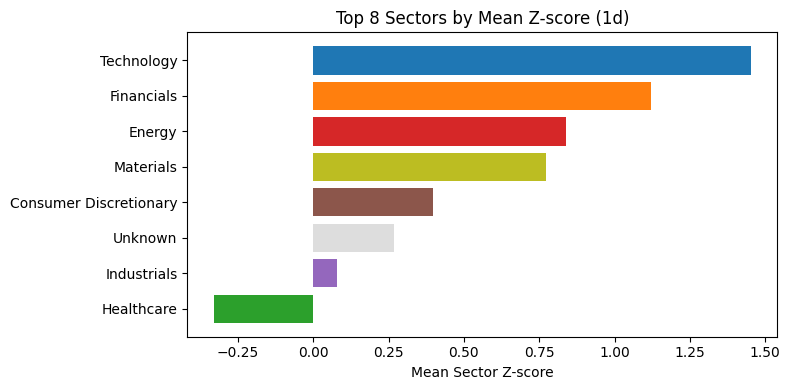

In [8]:
horizon=1
engine.plot_top_sectors(horizon=horizon)

**Purpose:**
Ranks and visualizes the sectors with the strongest volatility pressure for a chosen horizon.

**What it shows**
- Bar chart of top-N sectors sorted by a selected metric:
  - `sector_mean`: raw average `forecast_vol` within the sector

## 8️⃣ Ticker Heatmap

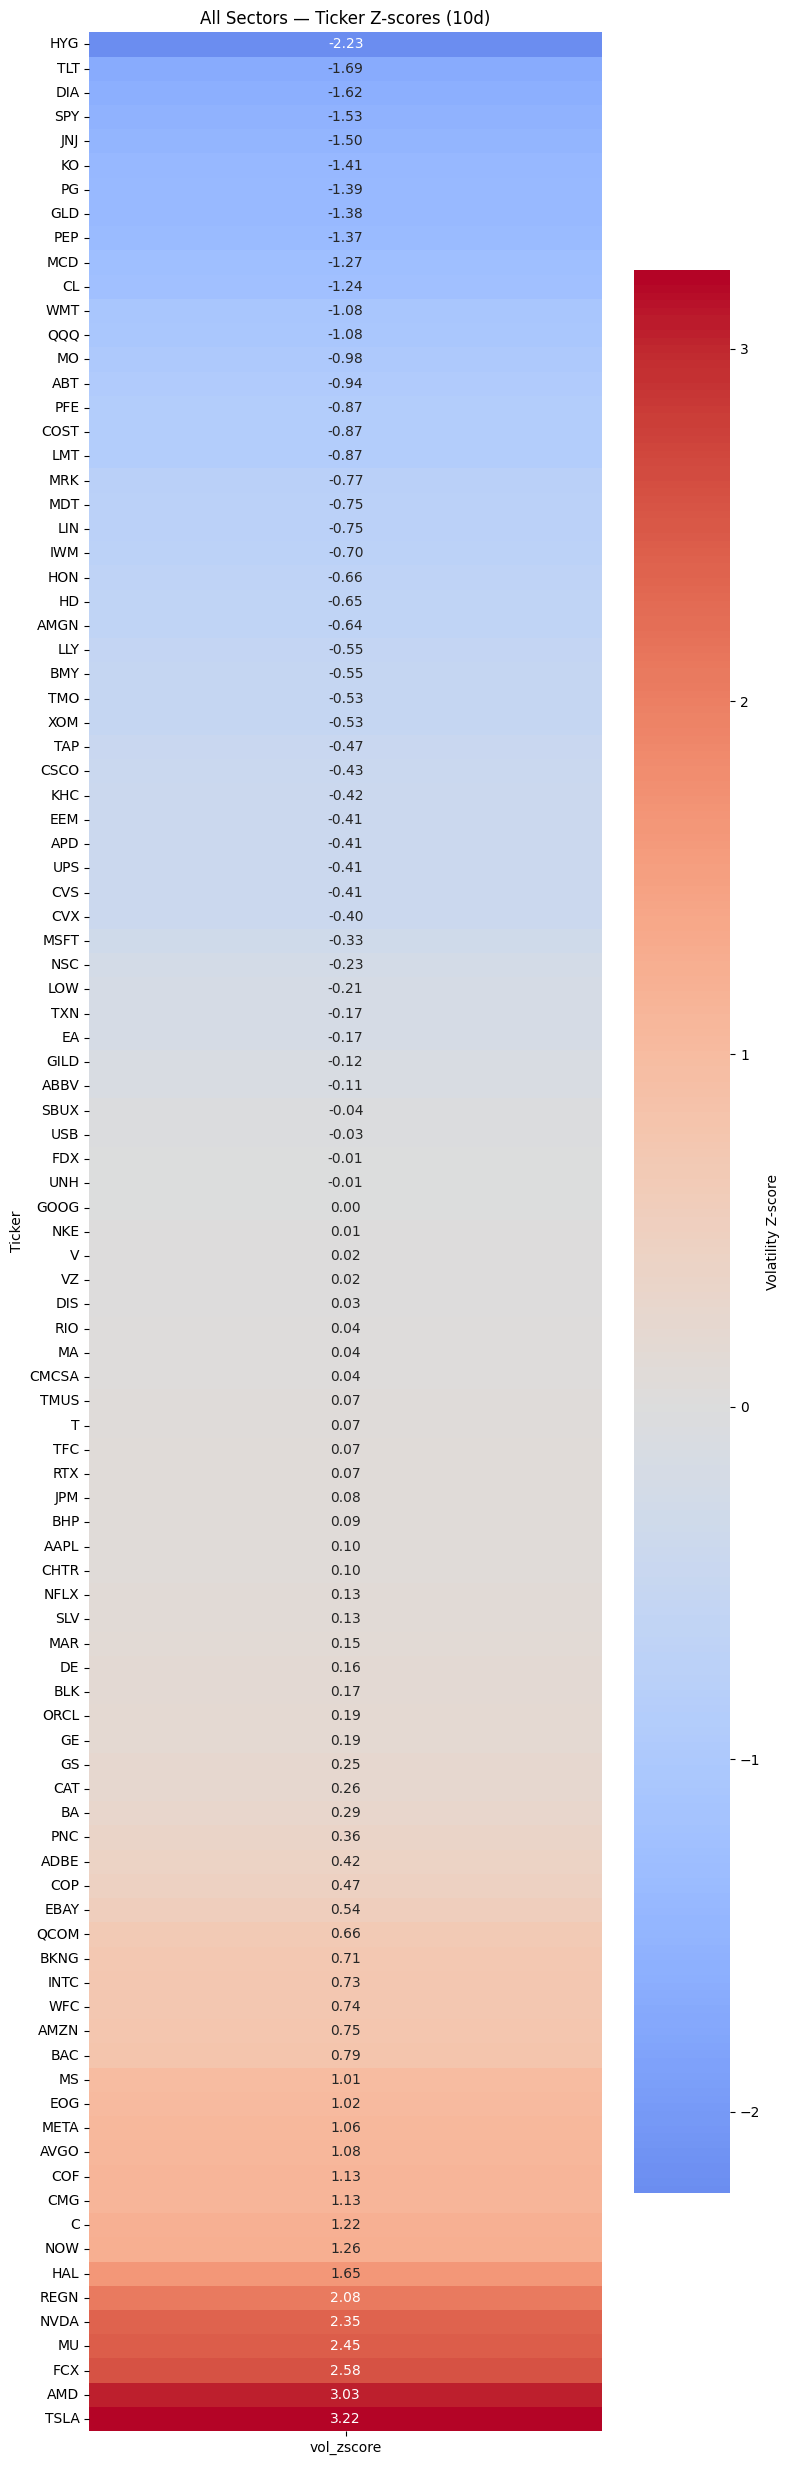

In [9]:
horizon=10
engine.plot_ticker_heatmap(horizon=horizon)

C:\Users\rahul\OneDrive\Documents\GitHub\VolSense\volsense_inference\signal_engine.py:586: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette=["green", "gray", "red"])


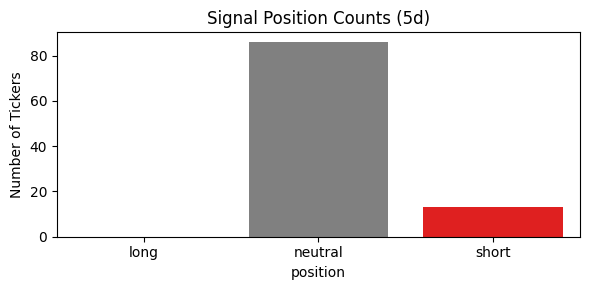

In [10]:
engine.plot_position_counts()

**Use Case:**
Visualizes **relative volatility elevation** across all tickers within the sample.
Darker reds indicate strong volatility build-up; blues indicate suppression or mean-reverting conditions.

## 9️⃣ Human-Readable Summary

In [11]:
for t in TICKERS[:5]:
    print(engine.ticker_summary(t))

SPY — 2025-10-31
  1d: fc=0.1891, today=0.1675 (+12.9%), z=-1.45, pos=short, regime=calm, sector=Index/ETF (z=-1.00, uni-rank=5%)
  5d: fc=0.1750, today=N/A (NaN), z=-1.49, pos=short, regime=calm, sector=Index/ETF (z=-1.04, uni-rank=4%)
  10d: fc=0.1567, today=N/A (NaN), z=-1.53, pos=short, regime=calm, sector=Index/ETF (z=-1.05, uni-rank=4%)
QQQ — 2025-10-31
  1d: fc=0.2459, today=0.2256 (+9.0%), z=-1.00, pos=neutral, regime=normal, sector=Index/ETF (z=-1.00, uni-rank=12%)
  5d: fc=0.2292, today=N/A (NaN), z=-1.03, pos=short, regime=calm, sector=Index/ETF (z=-1.04, uni-rank=13%)
  10d: fc=0.2028, today=N/A (NaN), z=-1.08, pos=short, regime=calm, sector=Index/ETF (z=-1.05, uni-rank=13%)
DIA — 2025-10-31
  1d: fc=0.1804, today=0.1311 (+37.6%), z=-1.53, pos=short, regime=calm, sector=Index/ETF (z=-1.00, uni-rank=3%)
  5d: fc=0.1668, today=N/A (NaN), z=-1.56, pos=short, regime=calm, sector=Index/ETF (z=-1.04, uni-rank=3%)
  10d: fc=0.1481, today=N/A (NaN), z=-1.62, pos=short, regime=calm,

This provides quick text-based insights, ideal for terminal monitoring or Slack/Telegram automation.

## 🔟 Launching the VolSense Dashboard

The **VolSense Dashboard** provides an interactive, trader-facing interface for exploring forecasts, sector analytics, and volatility signals.  
It wraps around the `SignalEngine` and `Forecast` modules and exposes them in a clean, Streamlit-powered UI.

### ▶️ How to Launch

From the root VolSense directory, run:

```bash
streamlit run volsense_inference/dashboard.py


## Exploring Forecasts and Signals Interactively

Once launched, the dashboard integrates seamlessly with VolSense model artifacts (e.g., `v109` or `v507`) and their forecast outputs.

### Step-by-Step Workflow

1. **Select Model and Tickers**  
   - Input the model version (e.g., `v109`) and desired tickers in the sidebar.  
   - Default start date is `2005-01-01` for consistent feature generation.

2. **Run Forecasts**  
   - Click **🚀 Run Forecasts** to trigger the pipeline:  
     - Fetch → Feature Engineering → Forecast → Signal Computation.  
   - The resulting forecasts populate all tabs dynamically.

3. **Analyze Signals**  
   - Navigate to the **Signal Table** tab to view the cross-sectional snapshot:  
     - Each row shows `vol_spread`, `term_spread_10v5`, `vol_zscore`, and classified `position`.  
     - Filters enable quick sorting by **sector**, **horizon**, **position**, or **regime**.

4. **Export Results**  
   - Use the 📥 **Export Predictions** or **Export CSV** buttons to download forecasts or signals for external analysis.

---

### Summary

The dashboard operationalizes the **VolSense research pipeline** — from data and model inference to signal visualization and sector-aware analytics — enabling both researchers and traders to interpret volatility dynamics in real time.


## **1️⃣1️⃣ Summary**

| Component         | Role                                           | Key Outputs                                          |
| ----------------- | ---------------------------------------------- | ---------------------------------------------------- |
| **Forecast**      | Generates multi-horizon volatility predictions | `pred_vol_1`, `pred_vol_5`, `pred_vol_10`            |
| **Analytics**     | Adds forecast-to-realized ratios & regimes     | `f/r_ratio`, `zscore`, `vol_regime`                  |
| **Signal Engine** | Aggregates & contextualizes forecasts          | `sector_heatmap`, `cross_horizon_corr`, `signals_df` |
| **Dashboard**     | Trader-facing dashboard with ticker and sector-wise analytics and filters       | visually appealing and interactive combined wrapper for `Forecaster`,`Analytics` and `Signal Engine`|